In [1]:
import pandas as pd
import numpy as np
from data.dataset import BaseDataset
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt
from data.crsp_dataset import CrspDataset
from pandas.tseries.offsets import DateOffset
from torch.utils.data import DataLoader
from portfolios.ReturnsPrediction import ReturnsPrediction
from models.neural_net.Optimize_Net import OptimizeNet
import tuning.tuning_utils as tu
import matplotlib.pyplot as plt

# Captum imports
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

path = '/home/ge65cuw/thesis/saved/final_results/img/feature_importance/'
path_for_model = '/home/ge65cuw/thesis/saved/results/ModelInterpretation/'

Device: cpu
Epochs: 100
Random seed set at: 21


In [2]:
batch_size = 2000 #5000

In [3]:
def visualize_importances(feature_names, importances, path, title="Average Feature Importances", plot=True, axis_title="Features", color_index = 5):
    
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df_reindexed = importance_df.reindex(importance_df.importance.abs().sort_values(ascending=False).index)
    importance_df_top = importance_df_reindexed.head(20) 
    importance_df = importance_df.sort_values(by='importance',ascending=True)
    x_pos = (np.arange(len(feature_names)))
    if plot:

        # Remove the plot frame lines. They are unnecessary chartjunk.
        # These are the "Tableau 20" colors as RGB.  
        tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
                    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
                    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
                    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
                    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

        # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
        for i in range(len(tableau20)):  
            r, g, b = tableau20[i]  
            tableau20[i] = (r / 255., g / 255., b / 255.)  
        path_top = path + '_fi_top20.png'
        default_path = path + '_fi_full.png'
        print(path)
        print(path_top)
        # path = path + '_feature_importance.png'
        path_categorized = path + '_fi_categorized.png'
        path_transposed = path + '_fi_full_transposed.png'

        x_pos = (np.arange(len(importance_df['feature'])))

        fig = plt.figure(figsize=(24,12))
        ax = plt.axes()
        ax.set_xticks(x_pos)
        
        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(True)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(True)  
        ax.set_xticklabels(importance_df['feature'], rotation=90, ha='center', fontsize=12)
        ax.bar(x_pos, importance_df['importance'],align='center', zorder=3, color=tableau20[color_index])
        plt.margins(y=0.01, x=.005)
        plt.axhline(y=0, color='grey', linestyle='-')
        fig.tight_layout()
        plt.savefig(default_path)
        

        # Transposed plot
        y_pos = (np.arange(len(importance_df['feature'])))

        fig = plt.figure(figsize=(8,35))
        ax = plt.axes()
        # ax.set_title('Feature Importance', fontsize=25)
        ax.set_yticks(y_pos)
        
        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(True)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(True)  
        ax.set_yticklabels(importance_df['feature'], rotation=0, fontsize=18)
        ax.xaxis.labelpad = 0
        ax.barh(y_pos, importance_df['importance'], align='center', zorder=3, color=tableau20[color_index])
        plt.margins(x=0.01, y=.001)
        # ax.xaxis.grid(True, linestyle='--',  zorder=0)
        plt.axvline(x=0, color='grey', linestyle='-')
        fig.tight_layout()
        plt.show()
        plt.savefig(path_transposed)
        


        # # Top 20 plot
        # x_pos = (np.arange(len(importance_df_top['feature'])))

        # fig = plt.figure(figsize=(12,9))
        # ax = plt.axes()
        # ax.get_xaxis().tick_bottom()
        # ax.get_yaxis().tick_left()

        # ax.spines["top"].set_visible(False)  
        # ax.spines["bottom"].set_visible(True)  
        # ax.spines["right"].set_visible(False)  
        # ax.spines["left"].set_visible(True)  

        # # ax.set_title('Feature Importance - Top 20 (of '+str(len(feature_names))+')', fontsize=25)
        # ax.set_xticks(x_pos)
        # ax.set_xticklabels(importance_df_top['feature'], rotation=45, ha='right', fontsize=14)
        # ax.bar(x_pos, importance_df_top['importance'],align='center',  zorder=3, color=tableau20[color_index])
        # ax.xaxis.grid(True, linestyle='--',  zorder=0)
        # plt.axhline(y=0, color='grey', linestyle='-')
        # fig.tight_layout()
        # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        # # plt.yticks(range(-1, 1), fontsize=13)

        # # plt.ylim(-0.5, 0.5)

        # plt.tight_layout()
        # plt.show()
        # plt.savefig(path_top)

        # Top 20 plot - transposed
        importance_df_top = importance_df_top.sort_values(by='importance')
        y_pos = (np.arange(len(importance_df_top['feature'])))

        fig = plt.figure(figsize=(12,9))
        ax = plt.axes()
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(True)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(True)  

        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df_top['feature'], rotation=0, ha='right', fontsize=16)
            
        ax.barh(y_pos, importance_df_top['importance'],align='center',  zorder=3, color=tableau20[color_index])
        # ax.yaxis.grid(True, linestyle='--',  zorder=0)
        ax.xaxis.grid(True, linestyle='--',  zorder=0)
        plt.axvline(x=0, color='grey', linestyle='-')
        fig.tight_layout()
        plt.margins(x=.05, y=.05)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        # plt.tight_layout()
        plt.show()
        plt.savefig(path_top)

        # Plot by factor categories

        importance_df['cat'] = np.nan
        factors =  {
            'profitability': [
                'roaq',
                'CBOperProf',
                # 'Investment',
                # 'InvestPPEInv'
                ],
            'market': [
                'BetaLiquidityPS',
                'BetaTailRisk',
                'betaVIX',
                'SmileSlope',
                # 'std_turn'
                ],
            'growth': [
                'AssetGrowth',
                'ChEQ',
                'ChInv',
                'GrAdExp',
                # 'hire',
                # 'InvGrowth'
                ],
        'quality': [
            'fgr5yrLag',
            'FEPS',
            'BookLeverage',
            'NetDebtPrice'
        ],
        'value': [
            # 'Accruals',
            'AccrualsBM',
            'AM',
            'BMdec',
            # 'BookLeverage',
            # 'BPEBM',
            # 'EarningsStreak',
            # 'CF',
            'RDcap',
            # 'EP'
            ],
            'momentum':[
                'Mom12m',
                'Mom6m',
                'MomSeason',
                'MomOffSeason'
                # 'MomSeasonShort'
            ]
        }
        
        # fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
        # plt.subplots_adjust(hspace=0.5)
        # fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

        # loop through tickers and axes
        # for k, ax in zip(factors.keys(), axs.ravel()):

        # fig = plt.figure(figsize=(12,9))
        # i = 0
        # for k,v in factors.items():
        #     i += 1
        #     imp_df = importance_df.loc[importance_df.feature.isin(v)].copy()
        #     ax = fig.add_subplot(3,2,i)
            
        #     x_pos = (np.arange(len(imp_df['feature'])))

        #     ax.get_xaxis().tick_bottom()
        #     ax.get_yaxis().tick_left()

        #     # ax.spines["top"].set_visible(False)  
        #     # ax.spines["bottom"].set_visible(True)  
        #     # ax.spines["right"].set_visible(False)  
        #     # ax.spines["left"].set_visible(True)  

        #     ax.set_xticks(x_pos)
        #     ax.set_xticklabels(imp_df['feature'], rotation=45, ha='right', fontsize=14)
        #     ax.bar(x_pos, imp_df['importance'], align='center',  zorder=3, color=tableau20[color_index])
        #     ax.set_title(k.capitalize())
        #     ax.xaxis.grid(True, linestyle='--',  zorder=0)
        #     plt.axhline(y=0, color='grey', linestyle='-')
        #     fig.tight_layout()
        #     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        # fig.tight_layout()

        # Transposed plot by category
        i=0
        fig = plt.figure(figsize=(12,6))
        for k,v in factors.items():
            i += 1
            imp_df = importance_df.loc[importance_df.feature.isin(v)].copy()
            ax = fig.add_subplot(2,3,i)
            
            y_pos = (np.arange(len(imp_df['feature'])))
            ax.get_xaxis().tick_bottom()
            ax.get_yaxis().tick_left()

            ax.spines["top"].set_visible(False)  
            ax.spines["bottom"].set_visible(True)  
            ax.spines["right"].set_visible(False)  
            ax.spines["left"].set_visible(True)  

            ax.set_yticks(y_pos)
            ax.set_yticklabels(imp_df['feature'], rotation=0, ha='right', fontsize=14)
            ax.barh(y_pos, imp_df['importance'], align='center',  zorder=3, color=tableau20[color_index])#, height=0.8)
            ax.set_title(k.capitalize())
            ax.xaxis.grid(True, linestyle='--',  zorder=0)
            plt.margins(x=.05, y=.05)
            plt.axvline(x=0, color='grey', linestyle='-')
            fig.tight_layout()
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        fig.tight_layout()
        plt.savefig(path_categorized)


In [4]:
def visualize_importances(feature_names, importances, path, title="Average Feature Importances", plot=True, axis_title="Features", color_index = 5):
    
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df_reindexed = importance_df.reindex(importance_df.importance.abs().sort_values(ascending=False).index)
    importance_df_top = importance_df_reindexed.head(20) 
    importance_df = importance_df.sort_values(by='importance',ascending=True)
    x_pos = (np.arange(len(feature_names)))
    if plot:

        tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
                    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
                    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
                    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
                    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

        for i in range(len(tableau20)):  
            r, g, b = tableau20[i]  
            tableau20[i] = (r / 255., g / 255., b / 255.)  
        path_top = path + '_fi_top20.png'
        default_path = path + '_fi_full.png'
        path_categorized = path + '_fi_categorized.png'
        path_transposed = path + '_fi_full_transposed.png'

      
        # Top 20 plot - transposed
        importance_df_top = importance_df_top.sort_values(by='importance')
        y_pos = (np.arange(len(importance_df_top['feature'])))

        fig = plt.figure(figsize=(17,15))
        ax = plt.axes()
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(True)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(True)  

        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df_top['feature'], rotation=0, ha='right', fontsize=16)
            
        ax.barh(y_pos, importance_df_top['importance'],align='center',  zorder=3, color=tableau20[color_index])
        ax.xaxis.grid(True, linestyle='--',  zorder=0)
        plt.axvline(x=0, color='grey', linestyle='-')
        plt.margins(x=.05, y=.05)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.tight_layout()
        fig.show()
        print(path_top)
        fig.savefig(path_top)

        # Plot by factor categories

        importance_df['cat'] = np.nan
        factors =  {
            'profitability': ['roaq','CBOperProf'],
            'market': ['BetaLiquidityPS','BetaTailRisk','betaVIX','SmileSlope'],
            'growth': [
                'AssetGrowth',
                'ChEQ',
                'ChInv',
                'GrAdExp',
                ],
        'quality': ['fgr5yrLag','FEPS','BookLeverage','NetDebtPrice'],
        'value': ['AccrualsBM','AM','BMdec','RDcap',],
        'momentum':[
                'Mom12m',
                'Mom6m',
                'MomSeason',
                'MomOffSeason'
            ]
        }
        
        # Transposed plot by category
        i=0
        fig = plt.figure(figsize=(12,6))
        for k,v in factors.items():
            i += 1
            imp_df = importance_df.loc[importance_df.feature.isin(v)].copy()
            ax = fig.add_subplot(2,3,i)
            
            y_pos = (np.arange(len(imp_df['feature'])))
            ax.get_xaxis().tick_bottom()
            ax.get_yaxis().tick_left()

            ax.spines["top"].set_visible(False)  
            ax.spines["bottom"].set_visible(True)  
            ax.spines["right"].set_visible(False)  
            ax.spines["left"].set_visible(True)  

            ax.set_yticks(y_pos)
            ax.set_yticklabels(imp_df['feature'], rotation=0, ha='right', fontsize=14)
            ax.barh(y_pos, imp_df['importance'], align='center',  zorder=3, color=tableau20[color_index])#, height=0.8)
            ax.set_title(k.capitalize())
            ax.xaxis.grid(True, linestyle='--',  zorder=0)
            plt.margins(x=.05, y=.05)
            plt.axvline(x=0, color='grey', linestyle='-')
            fig.tight_layout()
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        fig.tight_layout()
        plt.savefig(path_categorized)


# My Network 

In [5]:
Top_Net = 'model_16684133429276826.pt' 

In [6]:
dataset = BaseDataset()
df = dataset.df
df = df.drop('Beta',axis=1)

In [ ]:
idx = df.columns.to_list().index('ret')+1
feature_names = df.columns.to_list()[idx:]

## Prepare data

In [ ]:
test_dates = list(
    pd.period_range(
        start= (dt.datetime.strptime(str(202012), '%Y%m') + DateOffset(months=1)),
        periods=12,
        freq='M'
        ).strftime('%Y%m')
        .astype(int)
        )
train_dates = list(
    pd.period_range(
        start= (dt.datetime.strptime(str(198912), '%Y%m') + DateOffset(months=1)),
        periods=12*25,
        freq='M'
        ).strftime('%Y%m')
        .astype(int)
        )        

train = df.loc[df['yyyymm'].isin(train_dates)].copy()
test = df.loc[df['yyyymm'].isin(test_dates)].copy()

train = CrspDataset(train)
test = CrspDataset(test)

n_inputs = test.get_inputs()

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size)

train_iter = iter(train_loader)
train_inputs, train_target, train_labels = train_iter.next()

dataiter = iter(test_loader)
inputs, target, labels = dataiter.next()

In [ ]:
params = {
        "hidden_layer1": 512,
        "hidden_layer2": 256,
        "hidden_layer3": 64,
        "hidden_layer4": 0,
        "hidden_layer5": 0,
        "hidden_layer6": 0,
        "hidden_layer7": 0,
        "hidden_layer8": 0,
        "hidden_layer9": 0,
        "hidden_layer10": 0,
        "act_func": "ReLU",
        "learning_rate": 0.001,
        "optimizer":    "Nadam",
        "l1_lambda1":   0.001,
        "dropout_prob": 0.7,
        'batch_norm':   1,
        'patience':     10 
    } 
model = OptimizeNet(n_inputs=n_inputs, params=params)
optimizer = tu.map_optimizer(params, model.parameters())

## Load model

In [ ]:
model_path = path_for_model + 'models/' + Top_Net
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

OptimizeNet(
  (act_func): ReLU()
  (fc1): Sequential(
    (0): Linear(in_features=132, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
X_test = inputs.float()
X_test.requires_grad_()

X_train = train_inputs.float()
X_train.requires_grad_()

ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
# dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

nn3_ig_attr, delta = ig.attribute(X_test, return_convergence_delta=True)
# ig_nt_attr_test = ig_nt.attribute(X_test)
# dl_attr_test = dl.attribute(X_test)
# gs_attr_nn3_test = gs.attribute(X_test, X_train)
# fa_attr_test = fa.attribute(X_test)

## Integrated Gradients

In [ ]:
save_path = path + 'nn3'

/home/ge65cuw/thesis/saved/final_results/img/feature_importance/nn3_fi_top20.png


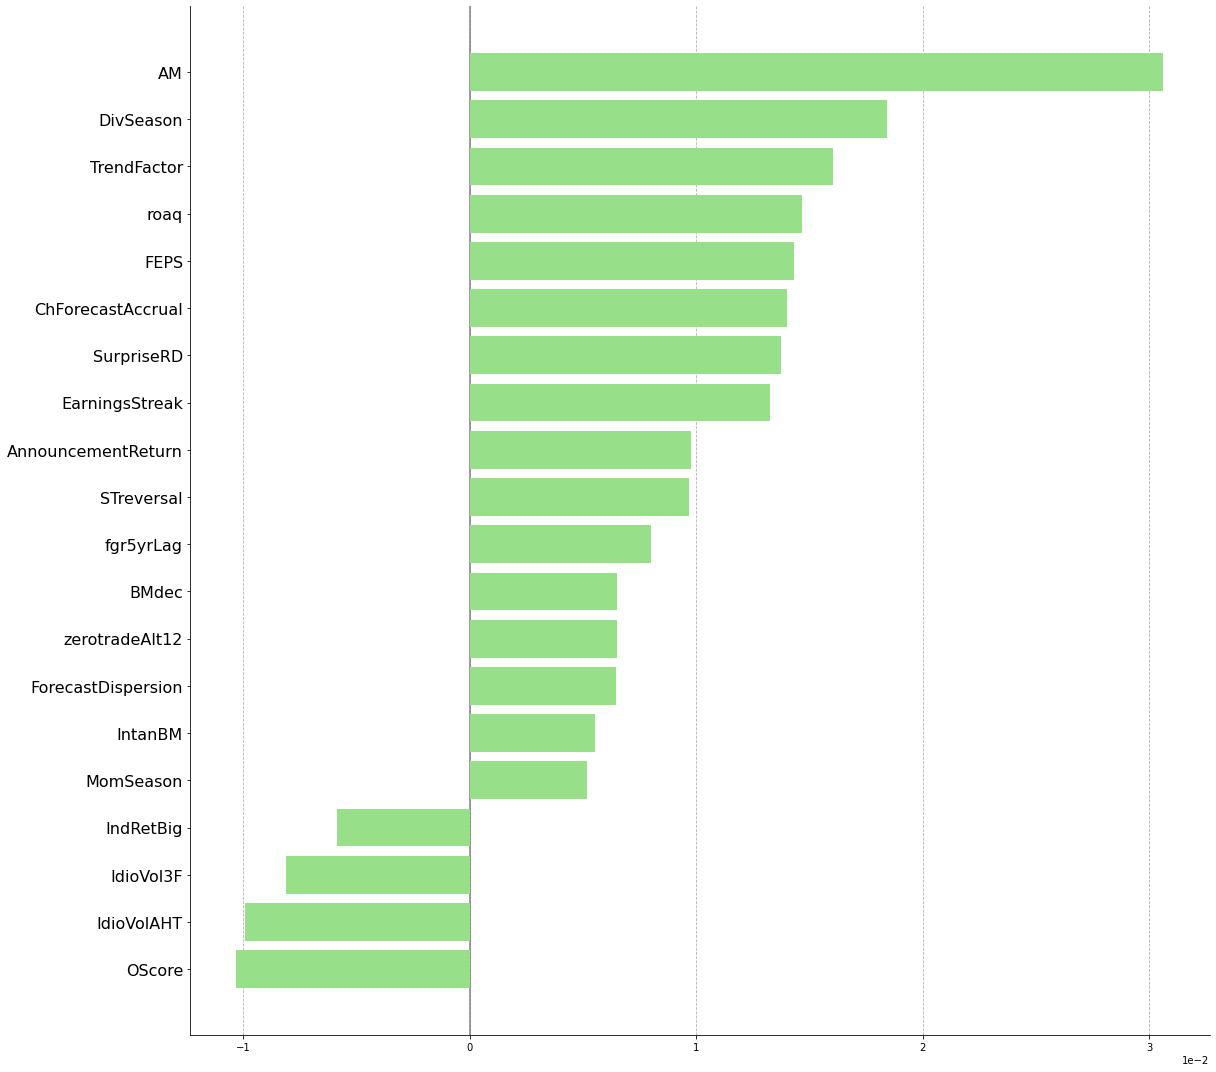

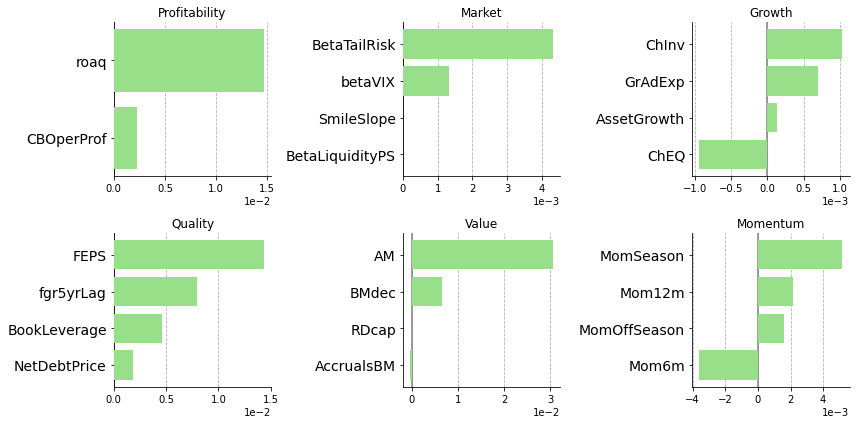

In [ ]:
nn3_attr = nn3_ig_attr.to('cpu').detach().numpy()
visualize_importances(feature_names, np.mean(nn3_attr, axis=0), save_path)


In [ ]:
nn3_importances = np.mean(nn3_attr, axis=0)
nn3_importance_df = pd.DataFrame({'feature': feature_names, 'nn3_importance': nn3_importances})
nn3_importance_df = nn3_importance_df.sort_values(by='feature', ascending=False)
nn3_importance_df

,feature,nn3_importance
131,zerotradeAlt12,0.006497
130,zerotradeAlt1,-0.003835
129,zerotrade,-0.001913
123,tang,0.002250
120,std_turn,0.001671
...,...,...
4,AnnouncementReturn,0.009768
2,Activism1,0.000000
1,AccrualsBM,-0.000363
0,Accruals,-0.001077


## Integrated Gradients - Noise Tunnel

In [ ]:
# attr = ig_nt_attr_test.to('cpu').detach().numpy()
# visualize_importances(feature_names, np.mean(attr, axis=0), path)

## Gradient Shap

In [ ]:
# attr_nn3 = gs_attr_nn3_test.to('cpu').detach().numpy()
# visualize_importances(feature_names, np.mean(attr_nn3, axis=0), path)

## Feature Ablation

In [ ]:
# attr = fa_attr_test.to('cpu').detach().numpy()
# visualize_importances(feature_names, np.mean(attr, axis=0), path)

# Gu Net

## Data prep

In [ ]:
Gu_net = 'model_16684484170777052.pt'
dataset = BaseDataset()
df = dataset.df
df = df.drop('Beta',axis=1)


idx = df.columns.to_list().index('ret')+1
feature_names = df.columns.to_list()[idx:]

test_dates = list(
    pd.period_range(
        start= (dt.datetime.strptime(str(202012), '%Y%m') + DateOffset(months=1)),
        periods=12,
        freq='M'
        ).strftime('%Y%m')
        .astype(int)
        )
train_dates = list(
    pd.period_range(
        start= (dt.datetime.strptime(str(198912), '%Y%m') + DateOffset(months=1)),
        periods=12*25,
        freq='M'
        ).strftime('%Y%m')
        .astype(int)
        )        

train = df.loc[df['yyyymm'].isin(train_dates)].copy()
test = df.loc[df['yyyymm'].isin(test_dates)].copy()

train = CrspDataset(train)
test = CrspDataset(test)

n_inputs = test.get_inputs()

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size)

train_iter = iter(train_loader)
train_inputs, train_target, train_labels = train_iter.next()

dataiter = iter(test_loader)
inputs, target, labels = dataiter.next()

Dataset loaded, the columns are:
Index(['permno', 'yyyymm', 'ret', 'Beta', 'Accruals', 'AccrualsBM',
       'Activism1', 'AM', 'AnnouncementReturn', 'AssetGrowth',
       ...
       'SurpriseRD', 'tang', 'Tax', 'TotalAccruals', 'TrendFactor', 'VolSD',
       'XFIN', 'zerotrade', 'zerotradeAlt1', 'zerotradeAlt12'],
      dtype='object', length=136)


## Load model

In [ ]:
model_path = path_for_model + 'models/' + Gu_net
checkpoint = torch.load(model_path)
checkpoint['params']['learning_rate']

0.05

In [ ]:
from models.neural_net.gu_et_al_NN4 import GuNN4
model = GuNN4(n_inputs)

model_path = path_for_model + 'models/' + Gu_net
checkpoint = torch.load(model_path)
optimizer = optim.Adam(model.parameters(),
            checkpoint['params']['learning_rate'],
            # Uncomment when will be using them as parameters
            betas=(
                checkpoint['params']['adam_beta_1'], 
                checkpoint['params']['adam_beta_2'])
                )

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

GuNN4(
  (net): Sequential(
    (0): Linear(in_features=132, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)

## Calculate importance

In [ ]:
X_test = inputs.float()
X_test.requires_grad_()

X_train = train_inputs.float()
X_train.requires_grad_()

ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
# dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

gu_ig_attr, delta = ig.attribute(X_test, return_convergence_delta=True)
# ig_nt_attr_test = ig_nt.attribute(X_test)
# dl_attr_test = dl.attribute(X_test)
# gs_attr_gu_test = gs.attribute(X_test, X_train)
# fa_attr_test = fa.attribute(X_test)

In [ ]:
save_path = path + 'gu'

## Integrated Gradients

/home/ge65cuw/thesis/saved/final_results/img/feature_importance/gu_fi_top20.png


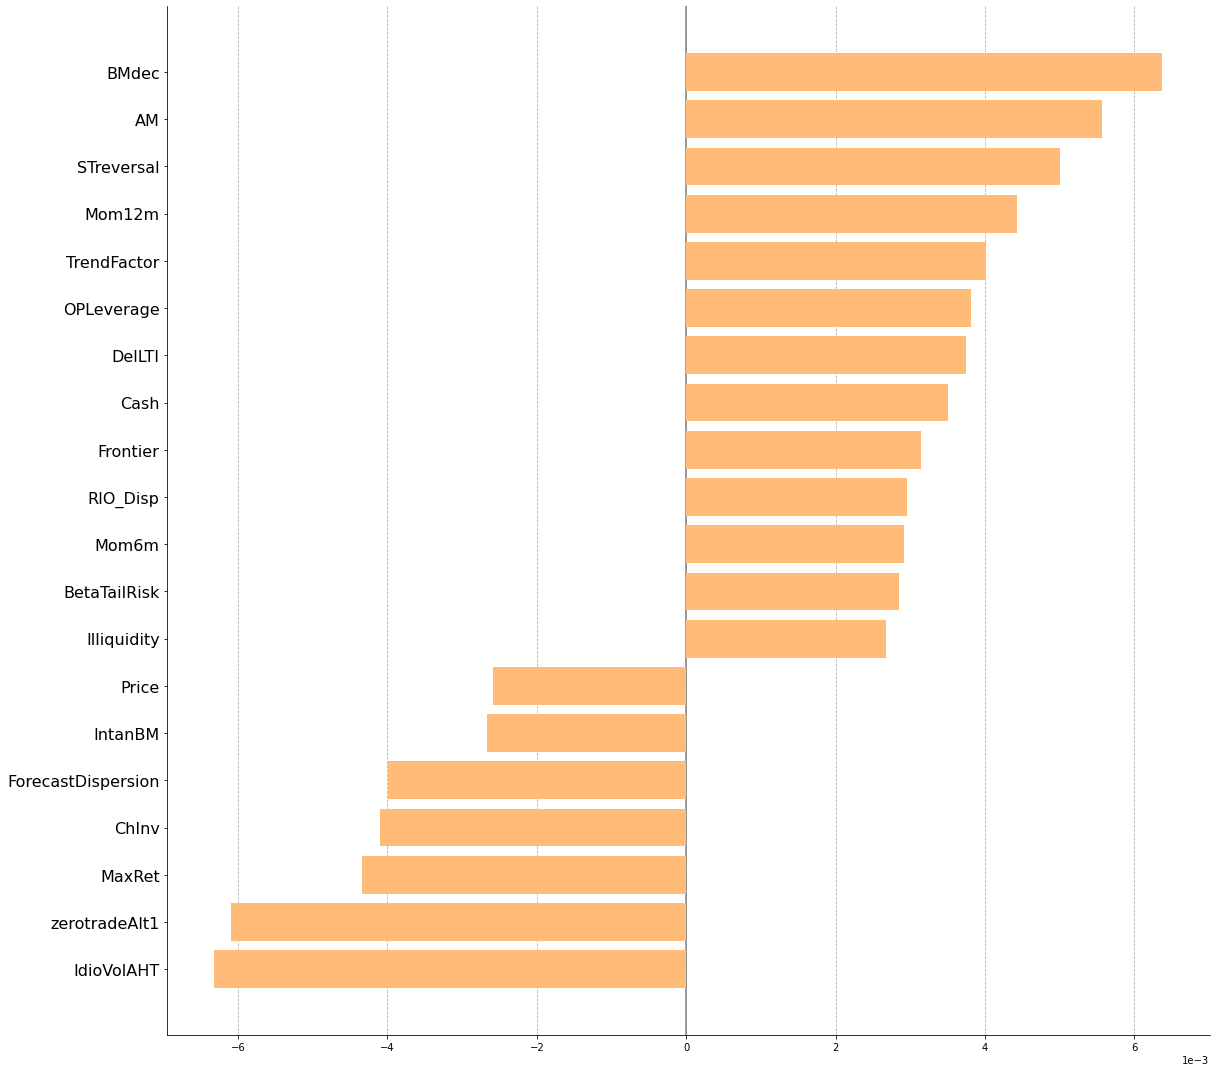

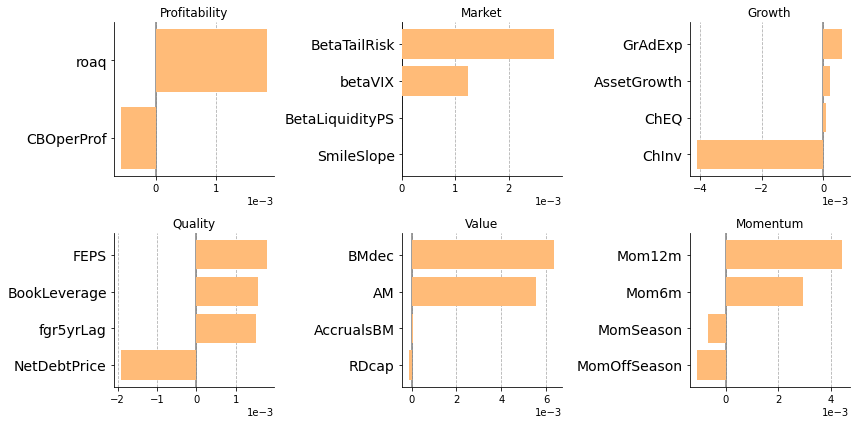

In [ ]:
gu_attr = gu_ig_attr.to('cpu').detach().numpy()
visualize_importances(feature_names, np.mean(gu_attr, axis=0), save_path, color_index=3)

# Convert importances to LaTeX table

In [ ]:
gu_importances = np.mean(gu_attr, axis=0)
gu_importance_df = pd.DataFrame({'feature': feature_names, 'gu_importance': gu_importances})
gu_importance_df = gu_importance_df.sort_values(by='gu_importance', ascending=False)
gu_importance_df

,feature,gu_importance
9,BMdec,0.006373
3,AM,0.005569
121,STreversal,0.005011
75,Mom12m,0.004424
126,TrendFactor,0.004018
...,...,...
51,ForecastDispersion,-0.003999
20,ChInv,-0.004103
74,MaxRet,-0.004339
130,zerotradeAlt1,-0.006100


In [ ]:
importances = nn3_importance_df.merge(gu_importance_df, on='feature')
importances.to_csv('/home/ge65cuw/thesis/saved/final_results/integrated_gradients.csv')


In [ ]:
import pandas as pd
pd.read_csv('/home/ge65cuw/thesis/saved/final_results/integrated_gradients.csv', index_col=0)
pd.set_option('display.float_format', '{:.2E}'.format)
importances = importances.sort_values(by='feature')
# importances
print(importances.style.hide(axis="index").to_latex())

In [ ]:
print(importances.style.hide(axis="index").to_latex())

\begin{tabular}{lrr}
feature & nn3_importance & gu_importance \\
AM & 0.030617 & 0.005569 \\
Accruals & -0.001077 & 0.002260 \\
AccrualsBM & -0.000363 & 0.000048 \\
Activism1 & 0.000000 & 0.000000 \\
AnnouncementReturn & 0.009768 & 0.002182 \\
AssetGrowth & 0.000129 & 0.000234 \\
BMdec & 0.006514 & 0.006373 \\
BPEBM & 0.003858 & -0.001114 \\
BetaLiquidityPS & 0.000000 & 0.000000 \\
BetaTailRisk & 0.004317 & 0.002853 \\
BookLeverage & 0.004632 & 0.001573 \\
CBOperProf & 0.002299 & -0.000569 \\
CF & 0.002392 & 0.001026 \\
Cash & -0.003502 & 0.003507 \\
CashProd & -0.001010 & 0.002320 \\
ChAssetTurnover & 0.000509 & -0.000460 \\
ChEQ & -0.000937 & 0.000079 \\
ChForecastAccrual & 0.014017 & 0.001866 \\
ChInv & 0.001035 & -0.004103 \\
ChInvIA & 0.000664 & 0.000769 \\
ChNAnalyst & 0.000000 & 0.000000 \\
ChNNCOA & 0.000208 & 0.000408 \\
ChNWC & -0.000421 & 0.001185 \\
ChTax & -0.002106 & -0.002090 \\
CompEquIss & -0.002247 & 0.000507 \\
CompositeDebtIssuance & 0.000447 & -0.001035 \\
ConvDebt

## Integrated Gradients - Noise Tunnel

In [ ]:
# attr = ig_nt_attr_test.to('cpu').detach().numpy()
# visualize_importances(feature_names, np.mean(attr, axis=0), path, color_index=3)

## Gradient Shap

In [ ]:
# attr = gs_attr_gu_test.to('cpu').detach().numpy()
# visualize_importances(feature_names, np.mean(attr, axis=0), path, color_index=3)

## Feature Ablation

In [ ]:
# attr = fa_attr_test.to('cpu').detach().numpy()
# visualize_importances(feature_names, np.mean(attr, axis=0), path, color_index=3)